In [1]:
import os
import tqdm
import glob
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
%matplotlib inline
plt.style.use('bmh')
import seaborn as sns

In [2]:
# parent directory
pdir = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction'

# load meta data

In [3]:
df_tdcs_meta = pd.read_csv(os.path.join(pdir, 'tdcsfog_metadata.csv'))
df_tdcs_meta.head()
#df_tdcs_meta.info()
df_defog_meta = pd.read_csv(os.path.join(pdir, 'defog_metadata.csv'))
df_defog_meta.head()

,Id,Subject,Visit,Medication
0,02ab235146,e1f62e,2,on
1,02ea782681,ae2d35,2,on
2,06414383cf,8c1f5e,2,off
3,092b4c1819,2874c5,1,off
4,0a900ed8a2,0e3d49,2,on


There are no NAN values (missing) as all features/columns have 833 count.

<Figure size 500x400 with 0 Axes>

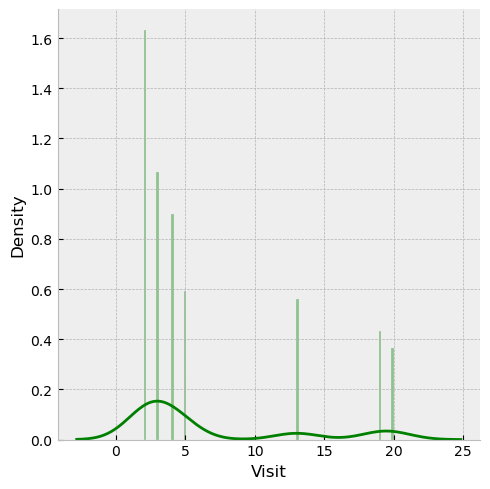

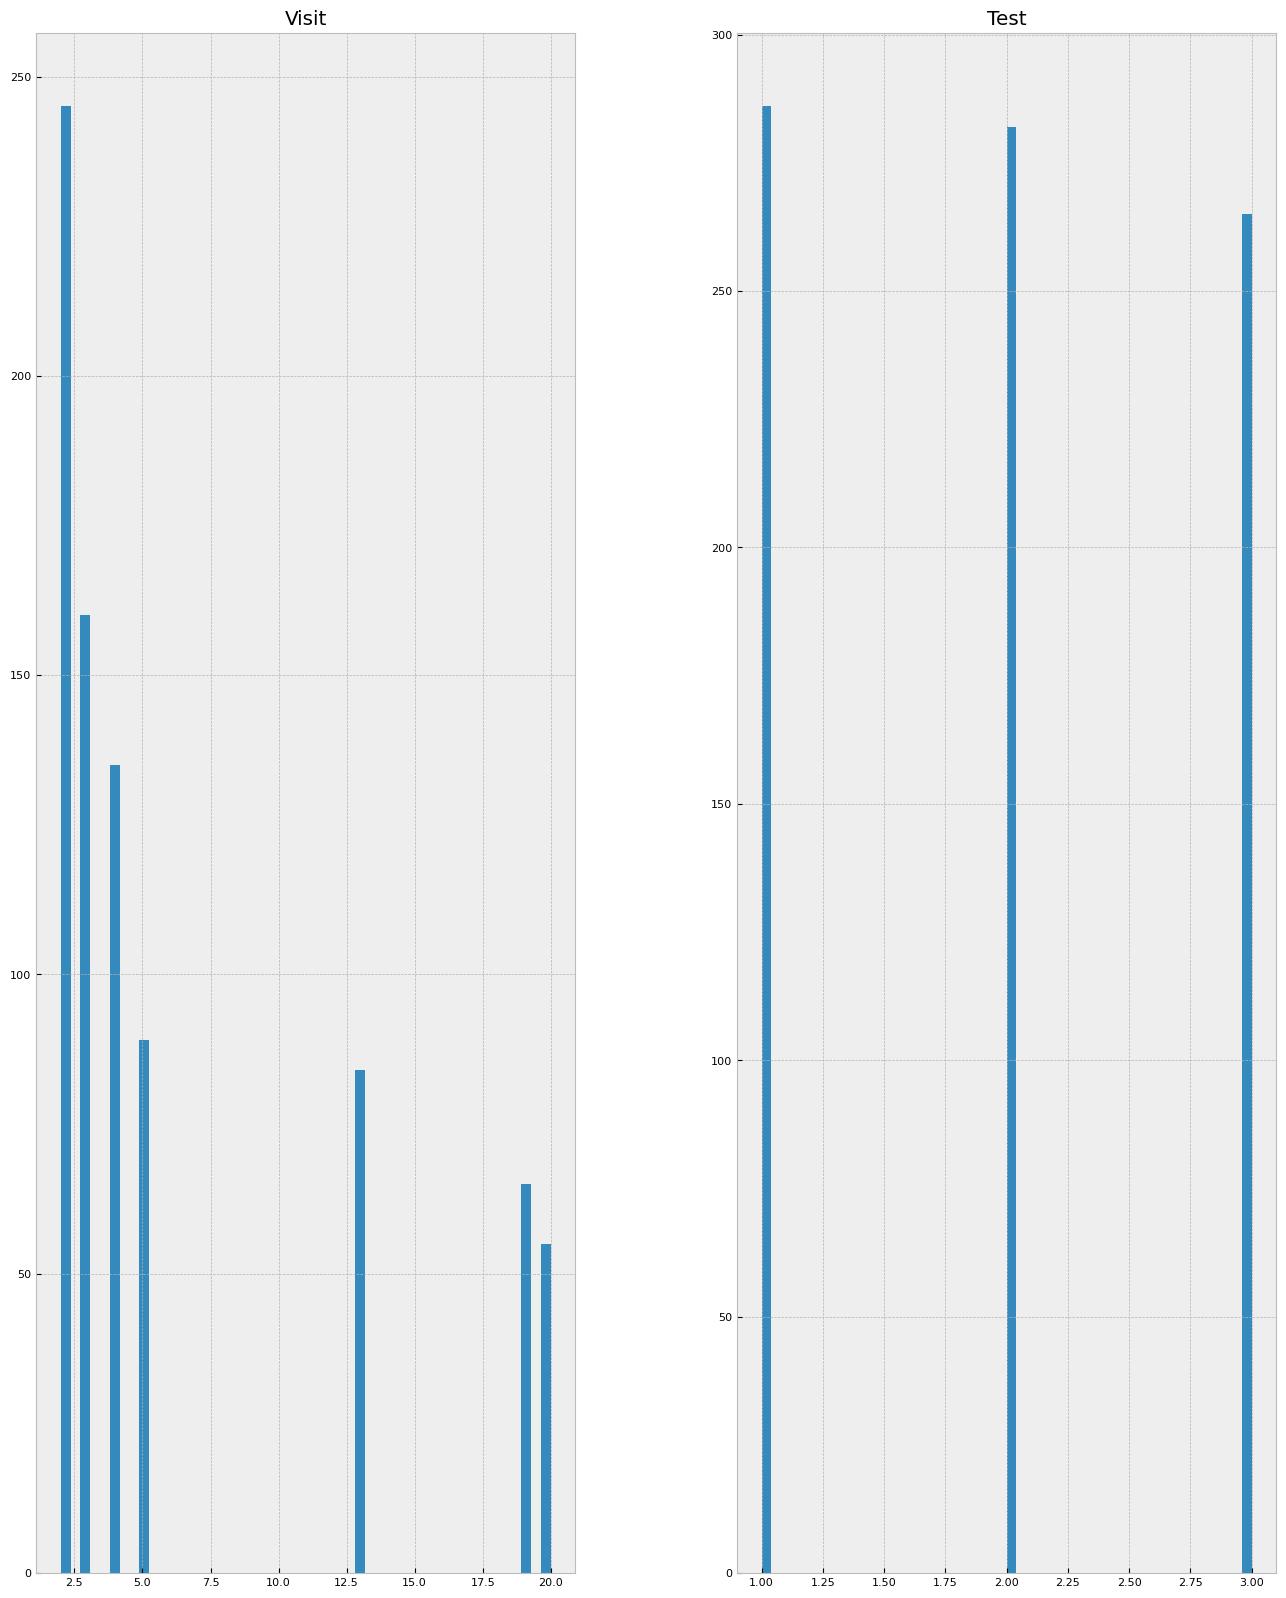

In [4]:
#print(df_tdcs_meta["Visit"].describe())
plt.figure(figsize=(5,4))
sns.displot(df_tdcs_meta['Visit'],  kde=True,
    stat="density", color='g', bins=100, kde_kws= dict(cut=3), alpha=0.4);
df_num = df_tdcs_meta.select_dtypes(include = ['float64', 'int64'])
df_num.head()
df_num.hist(figsize=(16,20), bins=50,xlabelsize=8, ylabelsize=8);

count     833
unique      2
top        on
freq      536
Name: Medication, dtype: object


<Figure size 900x800 with 0 Axes>

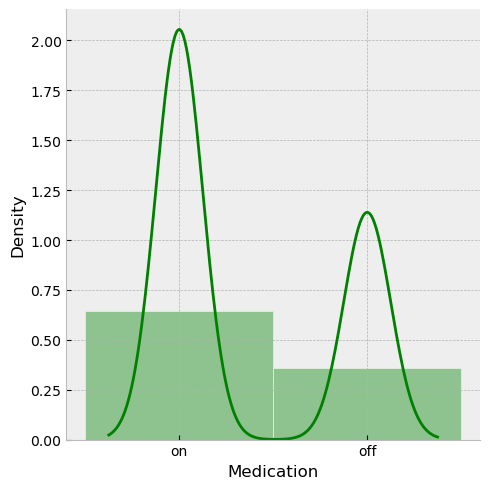

<Figure size 300x200 with 0 Axes>

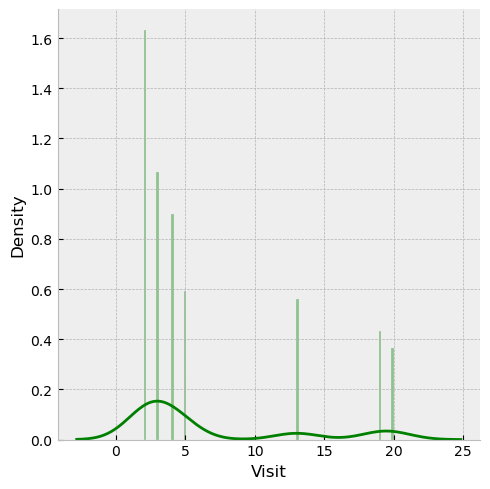

In [5]:
print(df_tdcs_meta["Medication"].describe())
plt.figure(figsize=(9,8))
sns.displot(df_tdcs_meta['Medication'],  kde=True,
    stat="density", color='g', bins=100, kde_kws= dict(cut=3), alpha=0.4);
plt.figure(figsize=(3,2))
sns.displot(df_tdcs_meta['Visit'],  kde=True,
    stat="density", color='g', bins=100, kde_kws= dict(cut=3), alpha=0.4);

count    833.000000
mean       6.460984
std        6.171914
min        2.000000
25%        2.000000
50%        4.000000
75%        5.000000
max       20.000000
Name: Visit, dtype: float64


<Figure size 900x800 with 0 Axes>

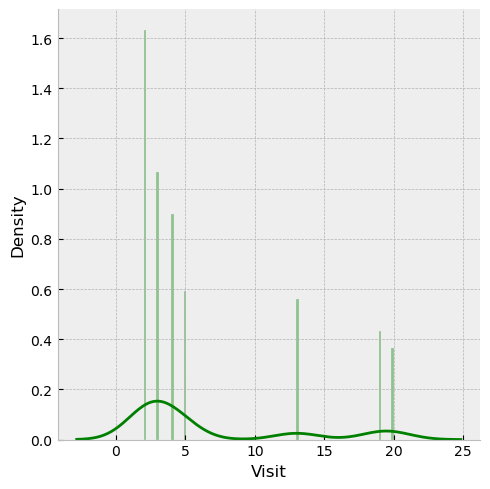

<Figure size 900x800 with 0 Axes>

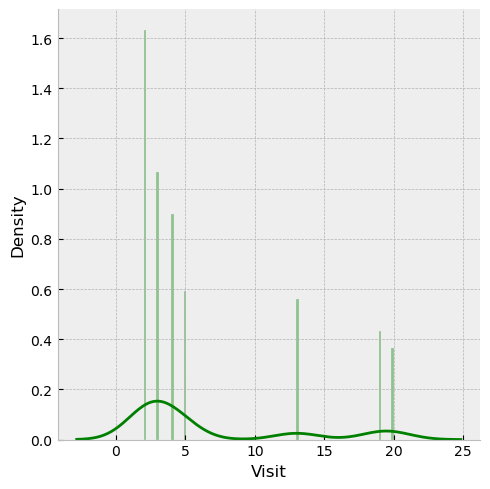

In [6]:
print(df_tdcs_meta["Visit"].describe())
plt.figure(figsize=(9,8))
sns.displot(df_tdcs_meta['Visit'],  kde=True,
    stat="density", color='g', bins=100, kde_kws= dict(cut=3), alpha=0.4);

plt.figure(figsize=(9,8))
sns.displot(df_tdcs_meta['Visit'],  kde=True,
    stat="density", color='g', bins=100, kde_kws= dict(cut=3), alpha=0.4);

In [7]:
df_subjects = pd.read_csv(os.path.join(pdir, 'subjects.csv'))
df_subjects.head()

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,00f674,2.0,63,M,27.0,43.0,49.0,24
1,00f674,1.0,63,M,27.0,31.0,30.0,26
2,02bc69,NaN,69,M,4.0,21.0,NaN,22
3,040587,2.0,75,M,26.0,52.0,69.0,21
4,040587,1.0,75,M,26.0,47.0,75.0,24


In [8]:
df_subjects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Subject       173 non-null    object 
 1   Visit         111 non-null    float64
 2   Age           173 non-null    int64  
 3   Sex           173 non-null    object 
 4   YearsSinceDx  173 non-null    float64
 5   UPDRSIII_On   172 non-null    float64
 6   UPDRSIII_Off  132 non-null    float64
 7   NFOGQ         173 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 10.9+ KB


In [9]:
df_subjects.describe()

,Visit,Age,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
count,111.000000,173.000000,173.000000,172.000000,132.000000,173.000000
mean,1.369369,67.763006,10.383931,34.273256,42.878788,17.121387
std,0.484823,7.972075,6.289191,12.732552,12.998550,7.575377
min,1.000000,28.000000,0.420000,5.000000,15.000000,0.000000
25%,1.000000,62.000000,6.000000,25.000000,33.000000,15.000000
50%,1.000000,68.000000,9.000000,35.000000,43.000000,19.000000
75%,2.000000,73.000000,15.000000,42.250000,49.250000,22.000000
max,2.000000,94.000000,30.000000,79.000000,91.000000,29.000000


# Load tdcsfog data

In [10]:
# list of all tdcsfog csv file path
tdcs_file_path = glob.glob(os.path.join(pdir, 'train', 'tdcsfog', '*.csv'), recursive=True)

# In this notebook, we limit the number of files to be read in order to reduce the time required for model training.
tdcs_file_path = tdcs_file_path[::100]

print(f'the number of files to be read: {len(tdcs_file_path)}')

the number of files to be read: 9


In [11]:
# Initialize a DataFrame to combine data from multiple CSV files.
df_tdcs = pd.DataFrame()

# load tdcsfog time series in combination with metadata.
for fp in tqdm.tqdm(tdcs_file_path):    
    
    # load data into a variable 'tmp'.
    tmp = pd.read_csv(fp)
    
    # get file Id from csv file name.
    file_id = os.path.basename(fp).replace(".csv", "")
    
    # get subject Id.
    subject = df_tdcs_meta.loc[df_tdcs_meta['Id'] == file_id, 'Subject'].iloc[0]
    
    # add metadata.
    tmp['Medication'] = df_tdcs_meta.loc[df_tdcs_meta['Id'] == file_id, 'Medication'].iloc[0]
    tmp['Age'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Age'].iloc[0]
    tmp['Sex'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Sex'].iloc[0]
    tmp['YearsSinceDx'] = df_subjects.loc[df_subjects['Subject'] == subject, 'YearsSinceDx'].iloc[0]
    tmp['NFOGQ'] =df_subjects.loc[df_subjects['Subject'] == subject, 'NFOGQ'].iloc[0]
    
    # concat the data
    df_tdcs = pd.concat([df_tdcs, tmp]).reset_index(drop=True)

100%|██████████| 9/9 [00:00<00:00, 29.61it/s]


In [12]:
# check the contents of the df_tdcs
df_tdcs.head()
df_tdcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53769 entries, 0 to 53768
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             53769 non-null  int64  
 1   AccV             53769 non-null  float64
 2   AccML            53769 non-null  float64
 3   AccAP            53769 non-null  float64
 4   StartHesitation  53769 non-null  int64  
 5   Turn             53769 non-null  int64  
 6   Walking          53769 non-null  int64  
 7   Medication       53769 non-null  object 
 8   Age              53769 non-null  int64  
 9   Sex              53769 non-null  object 
 10  YearsSinceDx     53769 non-null  float64
 11  NFOGQ            53769 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 4.9+ MB


# Load defog data

In [13]:
# list of all tdcsfog csv file path
defog_file_path = glob.glob(os.path.join(pdir, 'train', 'defog', '*.csv'), recursive=True)

# In this notebook, we limit the number of files to be read in order to reduce the time required for model training.
defog_file_path = defog_file_path[::50]

print(f'the number of files to be read: {len(defog_file_path)}')

the number of files to be read: 2


In [14]:
# Initialize a DataFrame to combine data from multiple CSV files.
df_defog = pd.DataFrame()

for fp in tqdm.tqdm(defog_file_path):
    # load data into a variable 'tmp'.
    tmp = pd.read_csv(fp)
    
    # get file Id from csv file name.
    file_id = os.path.basename(fp).replace(".csv", "")
    
    # get subject Id.
    subject = df_defog_meta.loc[df_defog_meta['Id'] == file_id, 'Subject'].iloc[0]
    
    # add metadata.
    tmp['Medication'] = df_defog_meta.loc[df_defog_meta['Id'] == file_id, 'Medication'].iloc[0]
    tmp['Age'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Age'].iloc[0]
    tmp['Sex'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Sex'].iloc[0]
    tmp['YearsSinceDx'] = df_subjects.loc[df_subjects['Subject'] == subject, 'YearsSinceDx'].iloc[0]
    tmp['NFOGQ'] =df_subjects.loc[df_subjects['Subject'] == subject, 'NFOGQ'].iloc[0]
    
    # extract data from the time period where Valid and Task are both True.
    tmp = tmp[(tmp['Valid'] == True) & (tmp['Task']==True)]
    tmp = tmp.drop(['Valid', 'Task'], axis=1)
    
    # concat the data
    df_defog = pd.concat([df_defog, tmp]).reset_index(drop=True)
    del tmp
    gc.collect()

100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


In [15]:
# check the contents of the df_defog
df_defog.head()


,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Medication,Age,Sex,YearsSinceDx,NFOGQ
0,1000,-1.015138,-0.071969,0.161124,0,0,0,on,72,M,16.0,18
1,1001,-1.018566,-0.057850,0.144988,0,0,0,on,72,M,16.0,18
2,1002,-1.037102,-0.054200,0.129327,0,0,0,on,72,M,16.0,18
3,1003,-1.036416,-0.060578,0.115451,0,0,0,on,72,M,16.0,18
4,1004,-1.012407,-0.069198,0.110121,0,0,0,on,72,M,16.0,18


# Prepare train data

array([[<AxesSubplot:title={'center':'Time'}>,
        <AxesSubplot:title={'center':'AccV'}>,
        <AxesSubplot:title={'center':'AccML'}>],
       [<AxesSubplot:title={'center':'AccAP'}>,
        <AxesSubplot:title={'center':'StartHesitation'}>,
        <AxesSubplot:title={'center':'Turn'}>],
       [<AxesSubplot:title={'center':'Walking'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'YearsSinceDx'}>],
       [<AxesSubplot:title={'center':'NFOGQ'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

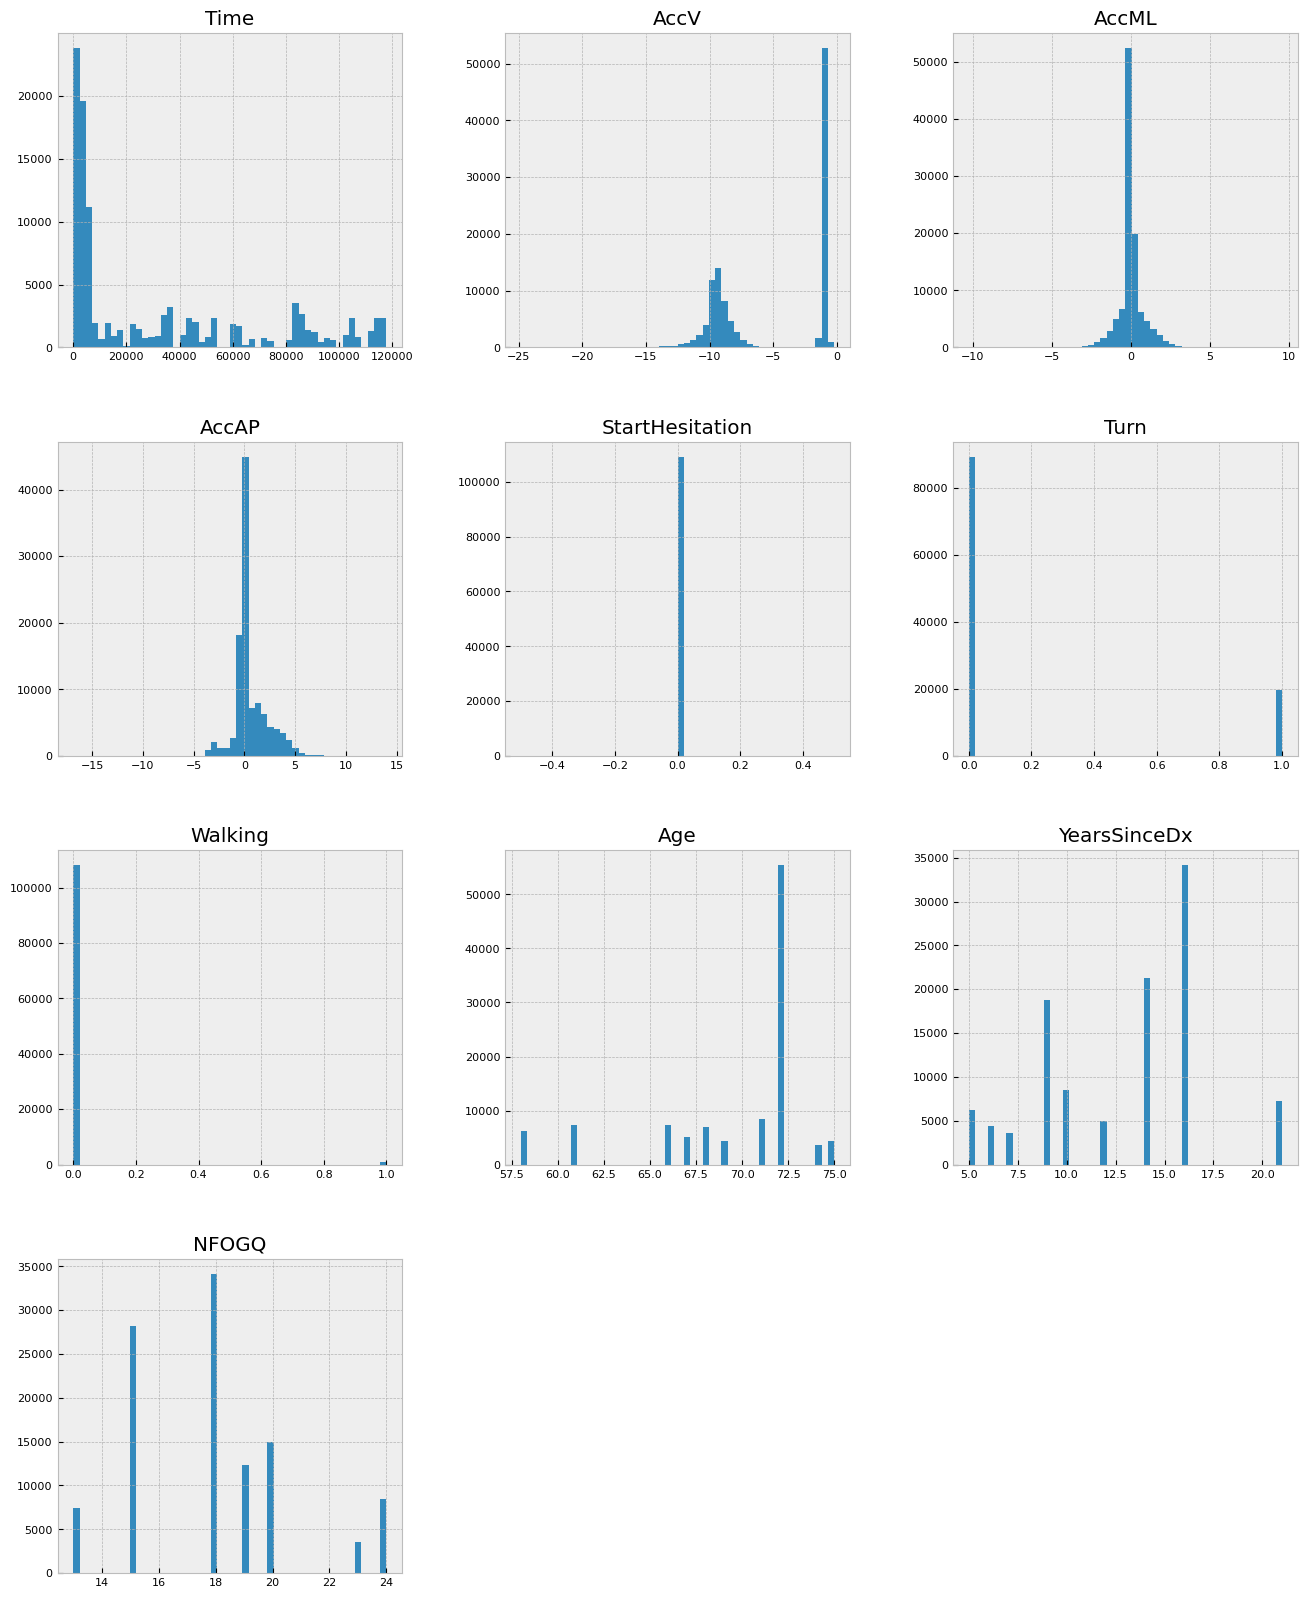

In [16]:
# concat tdcs and defog data.
df_train = pd.concat([df_tdcs, df_defog]).reset_index(drop=True)
#df_train.head()
df_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)


In [17]:
df_train['Medication'] = np.where(df_train['Medication']=='on', 1, 0)
df_train['Sex'] = np.where(df_train['Sex']=='M', 1, 0)
df_train.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Medication,Age,Sex,YearsSinceDx,NFOGQ
0,0,-9.665890,0.042550,0.184744,0,0,0,0,66,1,9.0,13
1,1,-9.672969,0.049217,0.184644,0,0,0,0,66,1,9.0,13
2,2,-9.670260,0.033620,0.193790,0,0,0,0,66,1,9.0,13
3,3,-9.673356,0.035159,0.184369,0,0,0,0,66,1,9.0,13
4,4,-9.671458,0.043913,0.197814,0,0,0,0,66,1,9.0,13


In [18]:
# split data into features and target.
y = df_train[['StartHesitation', 'Turn', 'Walking']]                       # target
X = df_train.drop(['StartHesitation', 'Turn', 'Walking', 'Time'], axis=1)  # feature


In [19]:
# check the contents of the target
y.head()

,StartHesitation,Turn,Walking
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [20]:
# check the contents of the feature
X.head()

,AccV,AccML,AccAP,Medication,Age,Sex,YearsSinceDx,NFOGQ
0,-9.665890,0.042550,0.184744,0,66,1,9.0,13
1,-9.672969,0.049217,0.184644,0,66,1,9.0,13
2,-9.670260,0.033620,0.193790,0,66,1,9.0,13
3,-9.673356,0.035159,0.184369,0,66,1,9.0,13
4,-9.671458,0.043913,0.197814,0,66,1,9.0,13


# Train RandomForestClassifier

In [21]:
#rf= RandomForestClassifier()
mlp= MLPClassifier(max_iter=2000, hidden_layer_sizes=(100,100), alpha=1e-4,activation='tanh',  solver='adam', random_state=3)
mlp.fit(X,y)

print("accuracy", mlp.score(X,y))


accuracy 0.8489300894034882


# Prepare test data

## Process the test data in the same way as the training data

In [22]:
# list of all tdcsfog csv file path
tdcs_test_file_path = glob.glob(os.path.join(pdir, 'test', 'tdcsfog', '*.csv'), recursive=True)
print(f'the number of files to be read: {len(tdcs_test_file_path)}')

the number of files to be read: 1


In [23]:
# Initialize a DataFrame to combine data from multiple CSV files.
df_tdcs_test = pd.DataFrame()

for fp in tqdm.tqdm(tdcs_test_file_path):
    
    # load data into a variable 'tmp'.
    tmp = pd.read_csv(fp)
    
    # get file Id from csv file name.
    file_id = os.path.basename(fp).replace(".csv", "")
    
    # get subject Id.
    subject = df_tdcs_meta.loc[df_tdcs_meta['Id'] == file_id, 'Subject'].iloc[0]
    
    # add metadata.
    tmp['Medication'] = df_tdcs_meta.loc[df_tdcs_meta['Id'] == file_id, 'Medication'].iloc[0]
    tmp['Age'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Age'].iloc[0]
    tmp['Sex'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Sex'].iloc[0]
    tmp['YearsSinceDx'] = df_subjects.loc[df_subjects['Subject'] == subject, 'YearsSinceDx'].iloc[0]
    tmp['NFOGQ'] =df_subjects.loc[df_subjects['Subject'] == subject, 'NFOGQ'].iloc[0]
    
    # add Id data to submit.
    tmp['Id'] = file_id + '_' + tmp['Time'].astype(str)
    
    # concat the data
    df_tdcs_test = pd.concat([df_tdcs_test, tmp]).reset_index(drop=True)

100%|██████████| 1/1 [00:00<00:00, 36.73it/s]


In [24]:
# check the contents of the df_tdcs_test
df_tdcs_test.head()

,Time,AccV,AccML,AccAP,Medication,Age,Sex,YearsSinceDx,NFOGQ,Id
0,0,-9.533939,0.566322,-1.413525,on,68,F,9.0,15,003f117e14_0
1,1,-9.536140,0.564137,-1.440621,on,68,F,9.0,15,003f117e14_1
2,2,-9.529345,0.561765,-1.429332,on,68,F,9.0,15,003f117e14_2
3,3,-9.531239,0.564227,-1.415490,on,68,F,9.0,15,003f117e14_3
4,4,-9.540825,0.561854,-1.429471,on,68,F,9.0,15,003f117e14_4


In [25]:
# list of all tdcsfog csv file path
defog_test_file_path = glob.glob(os.path.join(pdir, 'test', 'defog', '*.csv'), recursive=True)
print(f'the number of files to be read: {len(defog_test_file_path)}')

the number of files to be read: 1


In [26]:
# Initialize a DataFrame to combine data from multiple CSV files.
df_defog_test = pd.DataFrame()

for fp in tqdm.tqdm(defog_test_file_path):
    # load data into a variable 'tmp'.
    tmp = pd.read_csv(fp)
    
    # get file Id from csv file name.
    file_id = os.path.basename(fp).replace(".csv", "")
    
    # get subject Id.
    subject = df_defog_meta.loc[df_defog_meta['Id'] == file_id, 'Subject'].iloc[0]
    
    # add metadata.
    tmp['Medication'] = df_defog_meta.loc[df_defog_meta['Id'] == file_id, 'Medication'].iloc[0]
    tmp['Age'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Age'].iloc[0]
    tmp['Sex'] = df_subjects.loc[df_subjects['Subject'] == subject, 'Sex'].iloc[0]
    tmp['YearsSinceDx'] = df_subjects.loc[df_subjects['Subject'] == subject, 'YearsSinceDx'].iloc[0]
    tmp['NFOGQ'] =df_subjects.loc[df_subjects['Subject'] == subject, 'NFOGQ'].iloc[0]
    
    # add Id data to submit.
    tmp['Id'] = file_id + '_' + tmp['Time'].astype(str)
    
    # concat the data
    df_defog_test = pd.concat([df_defog_test, tmp]).reset_index(drop=True)

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


In [27]:
# check the contents of the df_defog_test
df_defog_test.head()

,Time,AccV,AccML,AccAP,Medication,Age,Sex,YearsSinceDx,NFOGQ,Id
0,0,-0.914652,-0.300851,0.298156,on,79,F,8.0,28,02ab235146_0
1,1,-0.914367,-0.301572,0.298325,on,79,F,8.0,28,02ab235146_1
2,2,-0.779540,-0.343197,0.275690,on,79,F,8.0,28,02ab235146_2
3,3,-0.993162,-0.270281,0.315775,on,79,F,8.0,28,02ab235146_3
4,4,-0.948767,-0.307849,0.297191,on,79,F,8.0,28,02ab235146_4


In [28]:
# concat tdcs and defog data.
df_test = pd.concat([df_tdcs_test, df_defog_test]).reset_index(drop=True)

# encode string columns into 0/1 format
df_test['Medication'] = np.where(df_test['Medication']=='on', 1, 0)
df_test['Sex'] = np.where(df_test['Sex']=='M', 1, 0)
display(df_test)

,Time,AccV,AccML,AccAP,Medication,Age,Sex,YearsSinceDx,NFOGQ,Id
0,0,-9.533939,0.566322,-1.413525,1,68,0,9.0,15,003f117e14_0
1,1,-9.536140,0.564137,-1.440621,1,68,0,9.0,15,003f117e14_1
2,2,-9.529345,0.561765,-1.429332,1,68,0,9.0,15,003f117e14_2
3,3,-9.531239,0.564227,-1.415490,1,68,0,9.0,15,003f117e14_3
4,4,-9.540825,0.561854,-1.429471,1,68,0,9.0,15,003f117e14_4
...,...,...,...,...,...,...,...,...,...,...
286365,281683,-0.899299,-0.232668,0.389147,1,79,0,8.0,28,02ab235146_281683
286366,281684,-0.901973,-0.233051,0.390114,1,79,0,8.0,28,02ab235146_281684
286367,281685,-0.901690,-0.231888,0.391896,1,79,0,8.0,28,02ab235146_281685
286368,281686,-0.899576,-0.232429,0.391106,1,79,0,8.0,28,02ab235146_281686


In [29]:
# split data into submission Id and feature.
Id = df_test['Id']                             # Id for submission data
X_test = df_test.drop(['Time', 'Id'], axis=1)  # feature of test data
X_test.head()
model = LogisticRegression()

# Predict and submit

In [30]:
# calculate prediction using trained RandomForestClassifier model.
#pred = rf.predict(X_test)
pred2 = mlp.predict(X_test)

In [31]:
#print(rf.score(X_test, pred))
print(mlp.score(X_test, pred2))

1.0


In [32]:
# Prepare submit data
submit = pd.DataFrame(Id, columns=['Id'])
submit['StartHesitation'] = pred2[:, 0]
submit['Turn'] = pred2[:, 1]
submit['Walking'] = pred2[:, 2]

In [33]:
display(submit)

,Id,StartHesitation,Turn,Walking
0,003f117e14_0,0,0,0
1,003f117e14_1,0,0,0
2,003f117e14_2,0,0,0
3,003f117e14_3,0,0,0
4,003f117e14_4,0,0,0
...,...,...,...,...
286365,02ab235146_281683,0,0,0
286366,02ab235146_281684,0,0,0
286367,02ab235146_281685,0,0,0
286368,02ab235146_281686,0,0,0


In [34]:
# Save the created submission data.
submit.to_csv('submission.csv', index=False)

<p style="font-size: 24px; font-weight: bold;">Congratulations!</p>

<p style="font-size: 16px;">You're now ready to submit your work on Kaggle!</p>

<p style="font-size: 16px;">Enjoy your experience on Kaggle!</p>